In [2]:
# Autoreload ensures that your python-files stay up-to-date: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Move back to the app/ directory
%cd ..

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/workspaces/seminars_as_branches


/opt/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Introduction to PyTorch

This notebook gives a brief introduction to [PyTorch](https://pytorch.org/).

This notebook is heavily inspired by [PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm

## Dataset and DataLoaders

One of the main functionalities that PyTorch provides is how it works with the data, which is at the core of any ML project.

**Questions:**
* **What are datasets used for?**
* **What are DataLoaders?**
* **What makes PyTorch datasets/dataloaders unique?**

In [4]:
# Download training and testing data from open datasets
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

# Show the classes of the dataset
assert training_data.classes == test_data.classes
classes = training_data.classes
classes

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
# Specify the number of samples in each batch
batch_size = 256

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Show the first batch of images
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")  # Single channel (grey-scale)
    print(f"Shape of y: {y.shape} {y.dtype}")  # Integers, not strings
    break

Shape of X [N, C, H, W]: torch.Size([256, 1, 28, 28])
Shape of y: torch.Size([256]) torch.int64


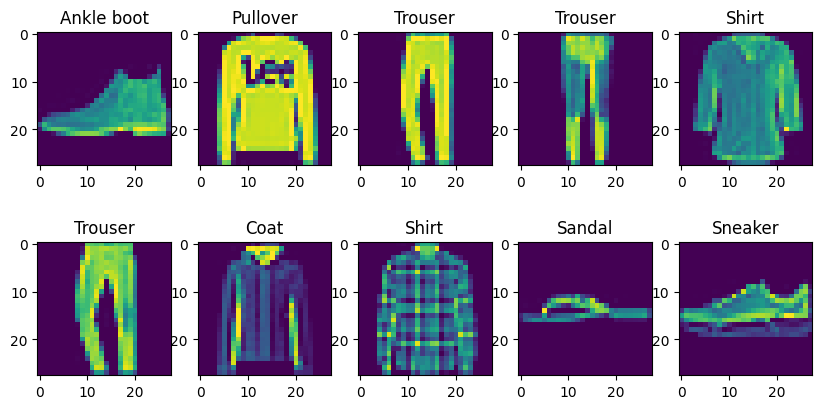

In [6]:
# Show some samples from the batch
_, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    axs[i // 5, i % 5].imshow(X[i, 0, :, :])
    axs[i // 5, i % 5].set_title(classes[y[i]])
plt.show()

## ML Models

Next to the data, PyTorch has a wide support to develop your statistical (ML) models to the greatest depths.

**Question: What type of model is good to use for image data?**

In [7]:
# Define model
class NeuralNetwork(nn.Module):
    """Simple Convolutional Neural Network."""

    def __init__(self) -> None:
        """Initialise the model."""
        super().__init__()
        self.conv1 = (
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
        )  # Input: 28x28x1, Output: 26x26x32
        self.mp1 = (nn.MaxPool2d(kernel_size=2, stride=2),)  # Input: 26x26x32, Output: 13x13x32
        self.conv2 = (
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        )  # Input: 13x13x32, Output: 11x11x64
        self.mp2 = (nn.MaxPool2d(kernel_size=2, stride=2),)  # Input: 11x11x64, Output: 5x5x64
        self.conv3 = (
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        )  # Input: 5x5x64, Output: 3x3x128
        self.mp3 = (nn.MaxPool2d(kernel_size=2, stride=2),)  # Input: 3x3x128, Output: 1x1x128
        self.lin1 = (nn.Linear(1 * 1 * 128, 64),)  # Input: 1x1x128, Output: 64
        self.lin2 = (nn.Linear(64, len(classes)),)  # Input: 64, Output: 10 (classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass throught the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (N, C, H, W).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (N, len_classes)
        """
        # Pass through the first CNN layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.mp1(x)

        # Pass through the second CNN layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.mp2(x)

        # Pass through the third CNN layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.mp3(x)

        # Flatten the output
        x = x.flatten(start_dim=1)

        # Pass through the first linear layer
        x = self.lin1(x)
        x = F.relu(x)

        # Pass through the second linear layer
        logits = self.lin2(x)
        return logits  # Returns logits, not probabilities


# Or, you can write it shorter
class NeuralNetwork(nn.Module):
    """Simple Convolutional Neural Network."""

    def __init__(self) -> None:
        """Initialise the model."""
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=32, kernel_size=3
            ),  # Input: 28x28x1, Output: 26x26x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Input: 26x26x32, Output: 13x13x32
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3
            ),  # Input: 13x13x32, Output: 11x11x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Input: 11x11x64, Output: 5x5x64
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=3
            ),  # Input: 5x5x64, Output: 3x3x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Input: 3x3x128, Output: 1x1x128
            nn.Flatten(start_dim=1),  # Input: 1x1x128, Output: 128
            nn.Linear(1 * 1 * 128, 64),  # Input: 128, Output: 64
            nn.ReLU(),
            nn.Linear(64, len(classes)),  # Input: 64, Output: 10 (classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass throught the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (N, C, H, W).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (N, len_classes)
        """
        return self.network(x)


model = NeuralNetwork()
print(model)

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [8]:
# Analyze number of parameters
sum(
    p.numel() for p in model.parameters() if p.requires_grad
)  # Requires_grad for trainable parameters

101578

In [9]:
# Example of a forward pass
logits = model(X)
print(f"Shape: {logits.shape}")
print(f"Values: {logits.min(), logits.max(), logits.mean()}")

Shape: torch.Size([256, 10])
Values: (tensor(-0.1170, grad_fn=<MinBackward1>), tensor(0.1140, grad_fn=<MaxBackward1>), tensor(-0.0067, grad_fn=<MeanBackward0>))


## Others

Next to the data and the model(s), PyTorch has support for other functionality that helps with training, evaluation, generating insights, ... .

**Questions:**
* **What is a loss function?**
* **Why would we keep metrics, other than a loss function?**
* **What is an optimizer?**
* **Are there other things you can think of that can help during training?**

In [10]:
# Loss functions
loss_fn = nn.CrossEntropyLoss()

In [11]:
# Metrics (custom)
accuracy_fn = lambda y_pred, y_true: torch.mean((torch.argmax(y_pred, dim=1) == y_true).float())

In [12]:
# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Train

Now we've defined all the model's components, let's train it!

In [13]:
# Define the train and test functions
def train(
    dataloader: DataLoader, model: NeuralNetwork, optimizer: torch.optim.Adam, epoch: int
) -> list[float]:
    """Train the model for one epoch."""
    model.train()
    losses, accuracies = [], []
    with tqdm(total=len(dataloader), desc=f"Training epoch={epoch}") as pbar:
        for X, y in dataloader:
            # Compute prediction error and accuracy
            pred = model(X)
            loss = loss_fn(pred, y)
            acc = accuracy_fn(pred, y)

            # Save the loss
            losses.append(loss.item())
            accuracies.append(acc.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            pbar.set_postfix(
                {"loss": sum(losses) / len(losses), "acc": sum(accuracies) / len(accuracies)}
            )
            pbar.update()
    return losses, accuracies


def test(dataloader: DataLoader, model: NeuralNetwork, epoch: int) -> dict[str, float]:
    """Test the model on the test set, return accuracy and loss."""
    model.eval()
    test_loss, test_acc = [], []
    with torch.no_grad(), tqdm(total=len(dataloader), desc=f"Validating epoch={epoch}") as pbar:
        for X, y in dataloader:
            pred = model(X)
            test_loss += [loss_fn(pred, y).item()] * X.shape[0]
            test_acc += [accuracy_fn(pred, y).item()] * X.shape[0]
            pbar.set_postfix(
                {"loss": sum(test_loss) / len(test_loss), "acc": sum(test_acc) / len(test_acc)}
            )
            pbar.update()
    return {"loss": sum(test_loss) / len(test_loss), "acc": sum(test_acc) / len(test_acc)}

In [14]:
# Start training the model
n_epochs = 3
losses_train, losses_val, acc_train, acc_val = [None], [None], [None], [None]

# Perform an initial validation
metrics = test(dataloader=test_dataloader, model=model, epoch=0)
losses_val[0] = metrics["loss"]
acc_val[0] = metrics["acc"]

# Train and validate the model over several epochs
for t in range(n_epochs):
    print(f"\n\nEpoch {t + 1}\n-------------------------------")
    losses_epoch, acc_epoch = train(
        dataloader=train_dataloader, model=model, optimizer=optimizer, epoch=t + 1
    )
    metrics = test(dataloader=test_dataloader, model=model, epoch=t + 1)

    # Save the losses and accuracies
    losses_train += losses_epoch
    acc_train += acc_epoch
    losses_val += [None] * len(losses_epoch)
    acc_val += [None] * len(acc_epoch)
    losses_val[-1] = metrics["loss"]
    acc_val[-1] = metrics["acc"]

    # Lot the end of the epoch
    print(f"Epoch {t + 1} - Test loss: {metrics['loss']:.4f}, Test accuracy: {metrics['acc']:.4f}")
print("Done!")

Validating epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]

Validating epoch=0: 100%|██████████| 40/40 [00:04<00:00,  9.59it/s, loss=2.3, acc=0.096]  




Epoch 1
-------------------------------


Validating epoch=1: 100%|██████████| 40/40 [00:03<00:00, 11.88it/s, loss=0.634, acc=0.771]


Epoch 1 - Test loss: 0.6337, Test accuracy: 0.7709


Epoch 2
-------------------------------


Validating epoch=2: 100%|██████████| 40/40 [00:03<00:00, 11.55it/s, loss=0.523, acc=0.81] 


Epoch 2 - Test loss: 0.5232, Test accuracy: 0.8104


Epoch 3
-------------------------------


Validating epoch=3: 100%|██████████| 40/40 [00:03<00:00, 11.90it/s, loss=0.53, acc=0.798] 

Epoch 3 - Test loss: 0.5300, Test accuracy: 0.7984
Done!


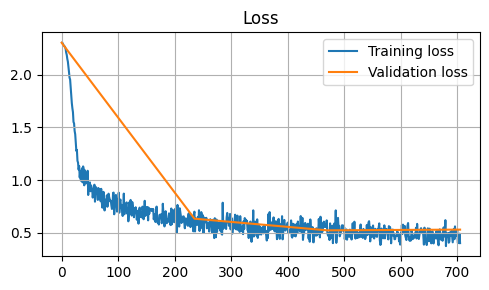

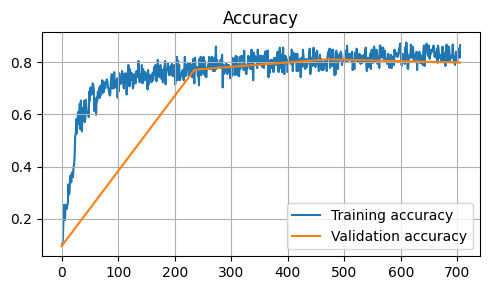

In [15]:
def _plot(x: list[float | None], label: str, zorder: int):
    i, x = zip(*[(i, x) for i, x in enumerate(x) if x is not None])
    plt.plot(i, x, label=label, zorder=zorder)


# Plot the losses
plt.figure(figsize=(5, 3))
plt.title("Loss")
_plot(losses_train, "Training loss", 1)
_plot(losses_val, "Validation loss", 2)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot the accuracies
plt.figure(figsize=(5, 3))
plt.title("Accuracy")
_plot(acc_train, "Training accuracy", 1)
_plot(acc_val, "Validation accuracy", 2)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



Epoch 4
-------------------------------


Validating epoch=1: 100%|██████████| 40/40 [00:02<00:00, 18.04it/s, loss=0.433, acc=0.844]


Epoch 1 - Test loss: 0.4331, Test accuracy: 0.8437


Epoch 5
-------------------------------


Validating epoch=2: 100%|██████████| 40/40 [00:02<00:00, 18.15it/s, loss=0.426, acc=0.846]


Epoch 2 - Test loss: 0.4264, Test accuracy: 0.8456


Epoch 6
-------------------------------


Validating epoch=3: 100%|██████████| 40/40 [00:02<00:00, 18.36it/s, loss=0.395, acc=0.857]


Epoch 3 - Test loss: 0.3946, Test accuracy: 0.8574


Epoch 7
-------------------------------


Validating epoch=4: 100%|██████████| 40/40 [00:02<00:00, 17.57it/s, loss=0.381, acc=0.862]


Epoch 4 - Test loss: 0.3812, Test accuracy: 0.8615


Epoch 8
-------------------------------


Validating epoch=5: 100%|██████████| 40/40 [00:02<00:00, 18.55it/s, loss=0.372, acc=0.866]


Epoch 5 - Test loss: 0.3724, Test accuracy: 0.8661


Epoch 9
-------------------------------


Validating epoch=6: 100%|██████████| 40/40 [00:02<00:00, 17.95it/s, loss=0.371, acc=0.865]


Epoch 6 - Test loss: 0.3713, Test accuracy: 0.8648


Epoch 10
-------------------------------


Validating epoch=7: 100%|██████████| 40/40 [00:02<00:00, 17.86it/s, loss=0.383, acc=0.864]


Epoch 7 - Test loss: 0.3831, Test accuracy: 0.8641


Epoch 11
-------------------------------


Validating epoch=8: 100%|██████████| 40/40 [00:02<00:00, 17.99it/s, loss=0.34, acc=0.877] 


Epoch 8 - Test loss: 0.3398, Test accuracy: 0.8775


Epoch 12
-------------------------------


Validating epoch=9: 100%|██████████| 40/40 [00:02<00:00, 18.32it/s, loss=0.351, acc=0.872]


Epoch 9 - Test loss: 0.3514, Test accuracy: 0.8723


Epoch 13
-------------------------------


Validating epoch=10: 100%|██████████| 40/40 [00:02<00:00, 17.82it/s, loss=0.341, acc=0.878]


Epoch 10 - Test loss: 0.3406, Test accuracy: 0.8778


Epoch 14
-------------------------------


Validating epoch=11: 100%|██████████| 40/40 [00:02<00:00, 18.71it/s, loss=0.363, acc=0.866]


Epoch 11 - Test loss: 0.3627, Test accuracy: 0.8657


Epoch 15
-------------------------------


Validating epoch=12: 100%|██████████| 40/40 [00:02<00:00, 17.08it/s, loss=0.337, acc=0.881]


Epoch 12 - Test loss: 0.3370, Test accuracy: 0.8806
Done!


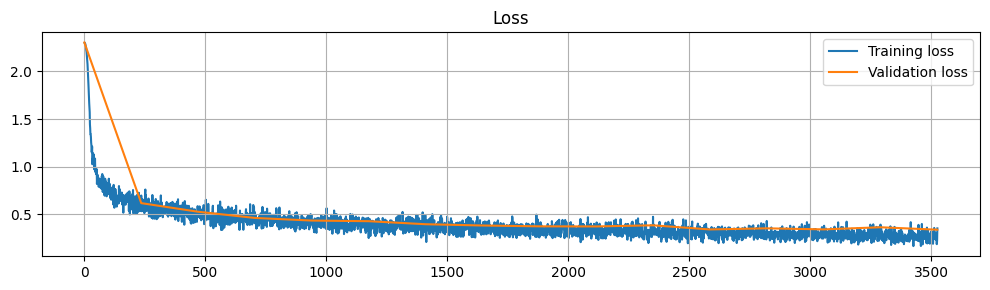

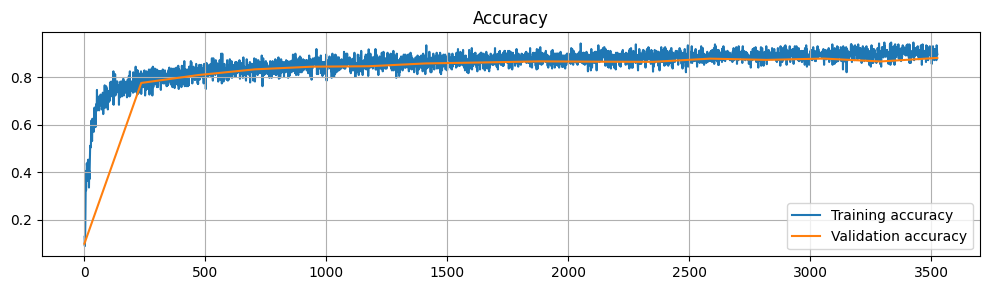

In [ ]:
# DON'T RUN THIS CELL (takes too long)

# Train and validate the model over several epochs
for t in range(12):
    print(f"\n\nEpoch {n_epochs + t + 1}\n-------------------------------")
    losses_epoch, acc_epoch = train(
        dataloader=train_dataloader, model=model, optimizer=optimizer, epoch=t + 1
    )
    metrics = test(dataloader=test_dataloader, model=model, epoch=t + 1)

    # Save the losses and accuracies
    losses_train += losses_epoch
    acc_train += acc_epoch
    losses_val += [None] * len(losses_epoch)
    acc_val += [None] * len(acc_epoch)
    losses_val[-1] = metrics["loss"]
    acc_val[-1] = metrics["acc"]

    # Lot the end of the epoch
    print(f"Epoch {t + 1} - Test loss: {metrics['loss']:.4f}, Test accuracy: {metrics['acc']:.4f}")
print("Done!")

# Plot the losses
plt.figure(figsize=(10, 3))
plt.title("Loss")
_plot(losses_train, "Training loss", 1)
_plot(losses_val, "Validation loss", 2)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot the accuracies
plt.figure(figsize=(10, 3))
plt.title("Accuracy")
_plot(acc_train, "Training accuracy", 1)
_plot(acc_val, "Validation accuracy", 2)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Questions:**
* **Why did the model stop improving?**
* **What can be the result of too long training?**
* **What's the difference in result between an over-parameterized and an under-parameterized model?**
* **How could we improve this model / the results?**

## Inference

Show how the model would operate in inference.

In [16]:
# Load in a sample
inp, target = test_data[0]
inp.shape, target

(torch.Size([1, 28, 28]), 9)

In [17]:
# Create a prediction for the sample
pred = model(inp.unsqueeze(0))[0]
pred  # Logits!

tensor([ -2.6784, -10.6728,  -7.0747,  -4.2317,  -4.0505,   3.9646,  -5.5483,
          5.4089,   0.2280,   7.6980], grad_fn=<SelectBackward0>)

In [18]:
# Turn into probabilities
probs = nn.Softmax(dim=0)(pred)
for cls, p in zip(classes, probs):
    print(f"{cls}: {p.item():>7f}")

T-shirt/top: 0.000028
Trouser: 0.000000
Pullover: 0.000000
Dress: 0.000006
Coat: 0.000007
Sandal: 0.021238
Shirt: 0.000002
Sneaker: 0.090031
Bag: 0.000506
Ankle boot: 0.888183


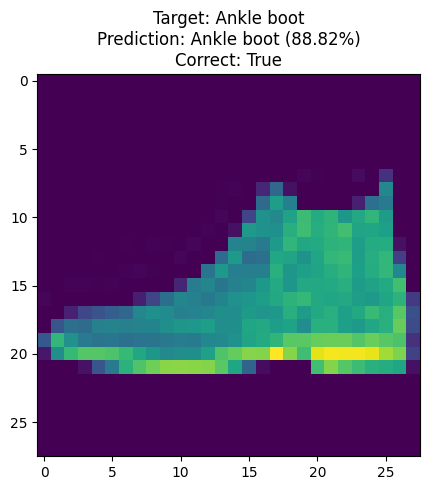

In [19]:
# Load in a sample
inp, target = test_data[0]

# Make a prediction with the model
pred = model(inp.unsqueeze(0))[0]
probs = nn.Softmax(dim=0)(pred)
idx = probs.argmax(0)

# Show the result
plt.figure(figsize=(5, 5))
plt.title(
    f"Target: {classes[target]}\nPrediction: {classes[idx]} ({100 * probs[idx]:.2f}%)\nCorrect: {target == idx}"
)
plt.imshow(inp[0].detach().numpy())
plt.tight_layout()
plt.show()

Searching for errors:   0%|          | 0/50 [00:00<?, ?it/s]

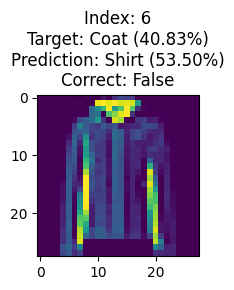

Searching for errors:  14%|█▍        | 7/50 [00:00<00:00, 43.01it/s]

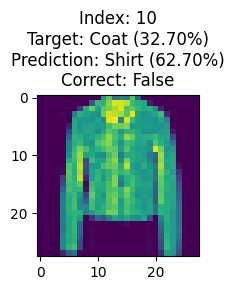

Searching for errors:  24%|██▍       | 12/50 [00:00<00:01, 37.34it/s]

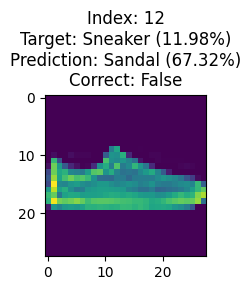

Searching for errors:  32%|███▏      | 16/50 [00:00<00:01, 32.79it/s]

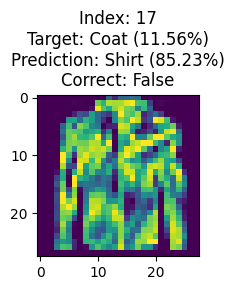

Searching for errors:  40%|████      | 20/50 [00:00<00:01, 24.24it/s]

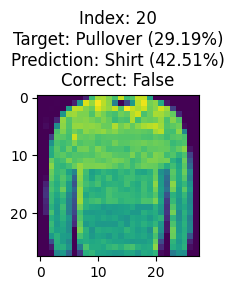

Searching for errors:  46%|████▌     | 23/50 [00:00<00:01, 23.88it/s]

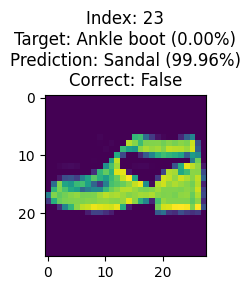

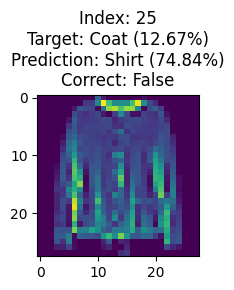

Searching for errors:  52%|█████▏    | 26/50 [00:01<00:01, 14.49it/s]

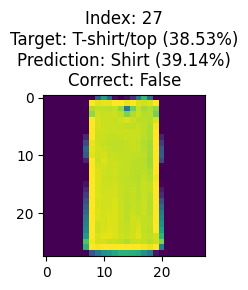

Searching for errors:  56%|█████▌    | 28/50 [00:01<00:01, 14.10it/s]

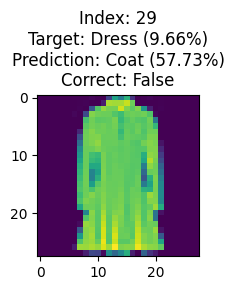

Searching for errors:  60%|██████    | 30/50 [00:01<00:01, 13.17it/s]

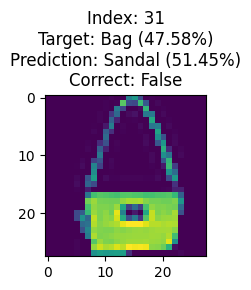

Searching for errors:  64%|██████▍   | 32/50 [00:01<00:01, 13.33it/s]

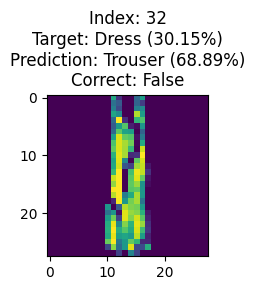

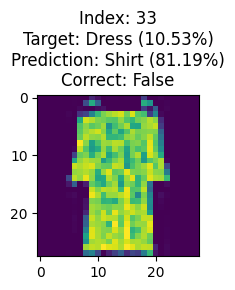

Searching for errors:  68%|██████▊   | 34/50 [00:02<00:01,  8.89it/s]

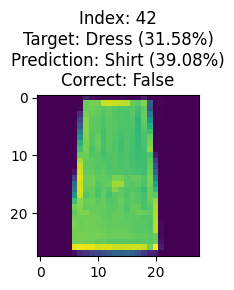

Searching for errors:  86%|████████▌ | 43/50 [00:02<00:00, 19.91it/s]

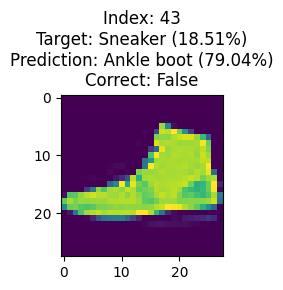

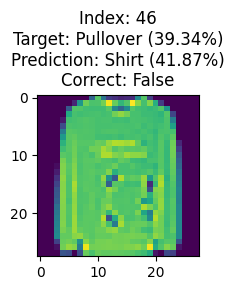

Searching for errors:  94%|█████████▍| 47/50 [00:02<00:00, 17.69it/s]

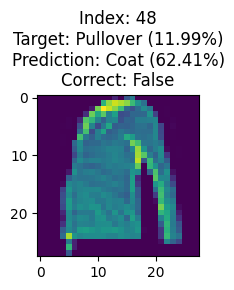

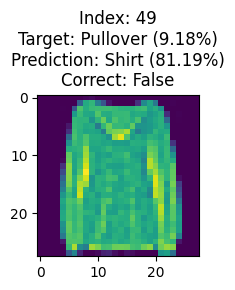

Searching for errors: 100%|██████████| 50/50 [00:02<00:00, 16.97it/s]


In [20]:
for i in tqdm(range(50), desc="Searching for errors"):
    # Load in a sample
    inp, target = test_data[i]

    # Make a prediction with the model
    pred = model(inp.unsqueeze(0))[0]
    probs = nn.Softmax(dim=0)(pred)
    idx = probs.argmax(0)

    # Show the result
    if target != idx:
        plt.figure(figsize=(3, 3))
        plt.title(
            f"Index: {i}\nTarget: {classes[target]} ({100 * probs[target]:.2f}%)\nPrediction: {classes[idx]} ({100 * probs[idx]:.2f}%)\nCorrect: {target == idx}"
        )
        plt.imshow(inp[0].detach().numpy())
        plt.tight_layout()
        plt.show()